# **Camera Calibration**

Implementation of an algorithm in **_python_** to estimate the intrinsic and extrinsic parameters (f_x, T_x, T_y, T_z  and matrix R). The results are compare with **_Octave's_** camera calibration tool. 

A [discussion](#discussion) considering the obtained results is conducted at the end of the notebook.

## **Naïve Calibration**

Image setup:

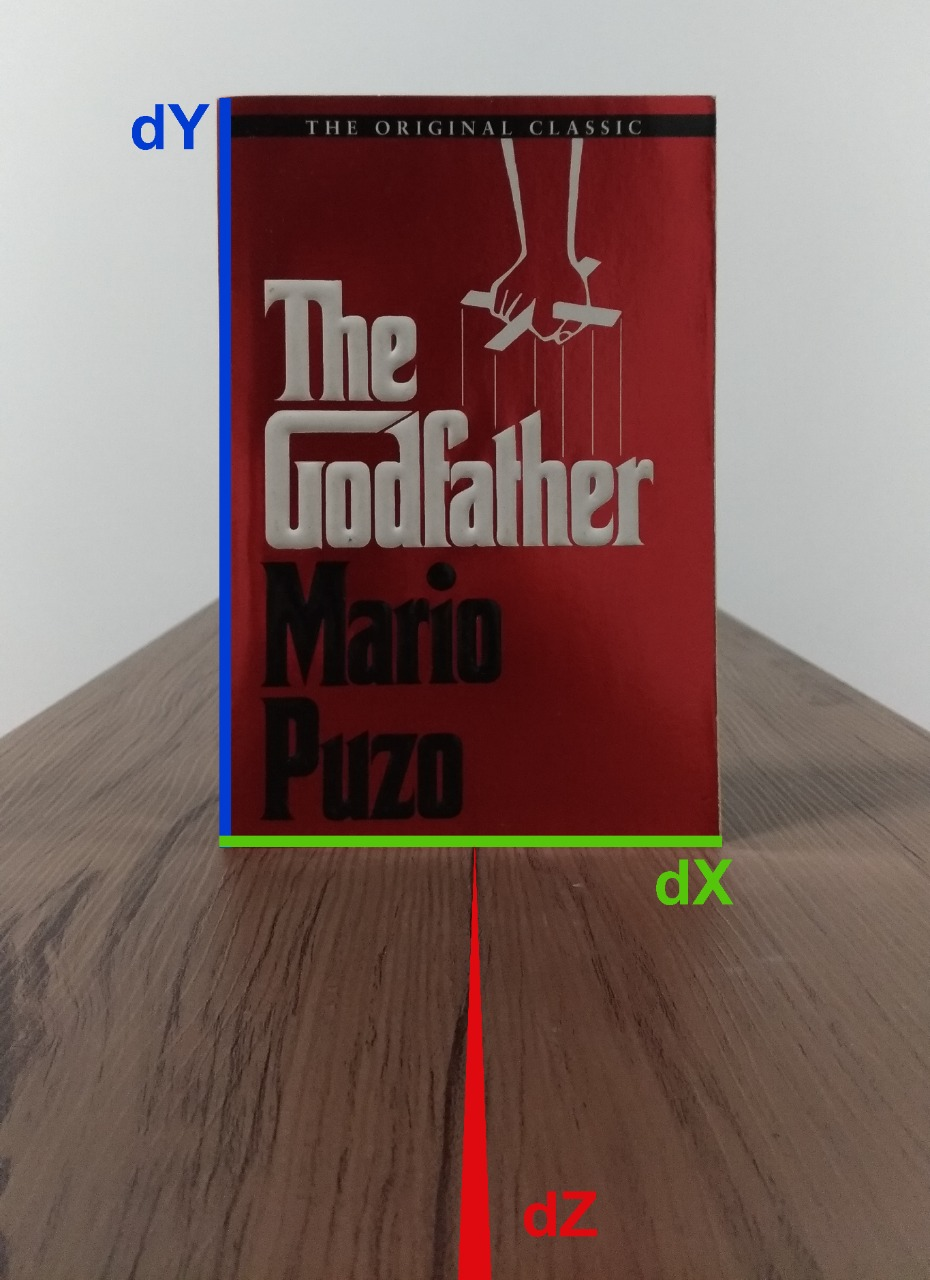

World measurements:
  *   **dX** = 135 mm
  *   **dY** = 202 mm
  *   **dZ** = 357 mm

Image measurements:
  *   **dx** = 1408 mm
  *   **dy** = 2116 mm

Camera information:

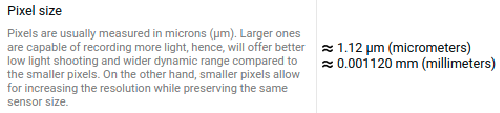

In [293]:
# Variables
dX = 135
dY = 202
dZ = 357
dx = 1408
dy = 2116
pixel_size = 0.001120

# Calculations
fx = (dx * dZ * pixel_size) / dX
fy = (dy * dZ * pixel_size) / dY

print('Focal length in X:', fx, 'mm')
print('Focal length in Y:', fy, 'mm')

Focal length in X: 4.17018311111111 mm
Focal length in Y: 4.1884229702970295 mm


## **Octave Calibration**

### Images:

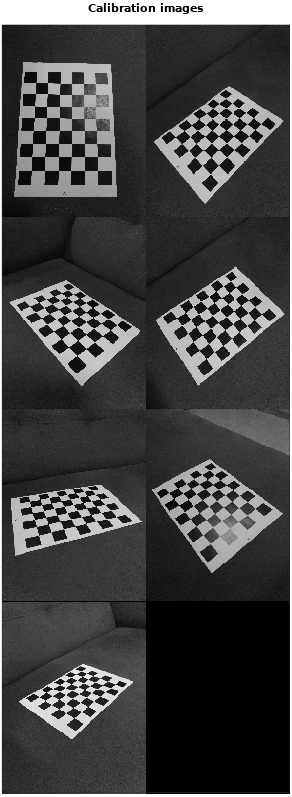

### Results:

```text
Calibration results after optimization (with uncertainties):
Focal Length:          fc = [ 3716.55713   3735.83714 ] +/- [ 109.25356   96.37580 ]
Principal point:       cc = [ 1791.76556   2330.49877 ] +/- [ 66.46925   114.46789 ]
Skew:             alpha_c = [ 0.00000 ] +/- [ 0.00000  ]   => angle of pixel axes = 90.00000 +/- 0.00000 degrees
Distortion:            kc = [ 0.18034   -0.95735   0.00048   0.00242  0.00000 ] +/- [ 0.06849   0.48583   0.00660   0.00759  0.00000 ]
Pixel error:          err = [ 2.62954   3.06481 ]
Note: The numerical errors are approximately three times the standard deviations (for reference).

Recommendation: Some distortion coefficients are found equal to zero (within their uncertainties).
To reject them from the optimization set est_dist=[1;1;0;0;0] and run Calibration
```

### Extrinsic parameters:

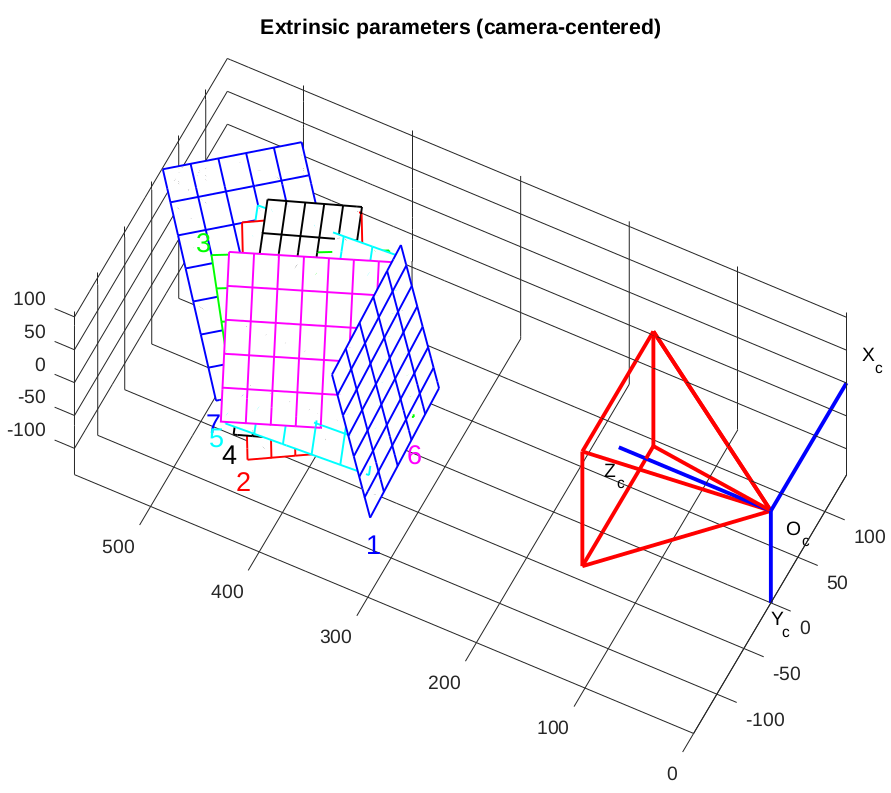

### Converting to millimeters

In [294]:
# We need to multiply by the pixel size to convert the focal length to mm
print('Focal length in X:', 3716.55713 * pixel_size)
print('Focal length in Y:', 3735.83714 * pixel_size)  

Focal length in X: 4.1625439856
Focal length in Y: 4.184137596799999


## **Python Implementation**

### Image setup:

48 points collected

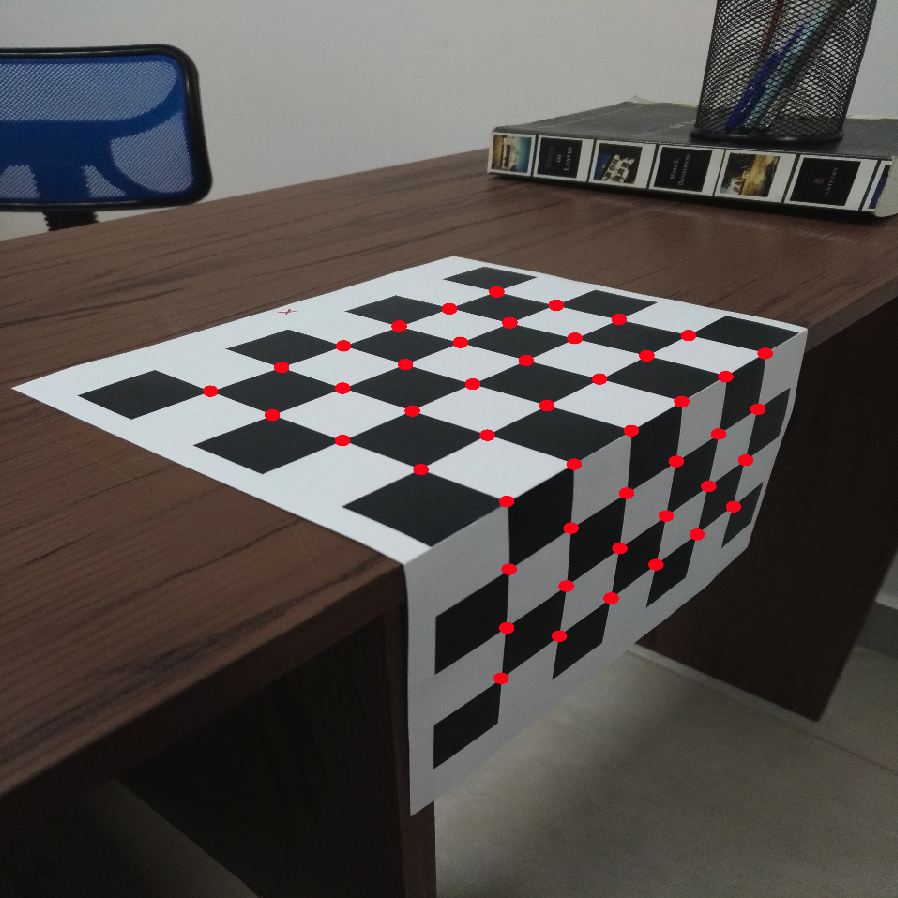

### Matrix construction and Singular Value Decomposition:

In [295]:
import math
import sys
import cv2
import numpy as np
import matplotlib as plt

# World Points
Xw=[0,28,56,84,112,112,112,112,0,28,56,84,112,112,112,112,0,28,56,84,112,112,112,112,0,28,56,84,112,112,112,112,0,28,56,84,112,112,112,112,0,28,56,84,112,112,112,112]
Yw=[0,0,0,0,0,0,0,0,28,28,28,28,28,28,28,28,56,56,56,56,56,56,56,56,84,84,84,84,84,84,84,84,112,112,112,112,112,112,112,112,140,140,140,140,140,140,140,140]
Zw=[0,0,0,0,0,-28,-56,-84,0,0,0,0,0,-28,-56,-84,0,0,0,0,0,-28,-56,-84,0,0,0,0,0,-28,-56,-84,0,0,0,0,0,-28,-56,-84,0,0,0,0,0,-28,-56,-84]

# Image Points
Xi=[    819,1059,1332,1635,1968,1977,1968,1947,
        1095,1332,1602,1893,2229,2217,2199,2172,
        1335,1575,1836,2124,2451,2433,2406,2373,
        1551,1788,2043,2328,2646,2625,2586,2547,
        1746,1980,2232,2511,2817,2790,2751,2706,
        1929,2160,2403,2673,2970,2943,2895,2847
    ]

Yi=[
        2025,2148,2280,2430,2595,2946,3249,3510,
        1902,2010,2127,2253,2403,2733,3033,3291,
        1791,1887,1989,2100,2229,2553,2838,3096,
        1689,1773,1866,1962,2079,2388,2670,2922,
        1599,1671,1752,1842,1950,2247,2517,2766,
        1512,1581,1653,1737,1830,2118,2382,2622
    ]

# Get the number of points
nr_points = len(Xi)

# Generates matrix A
A = np.zeros((nr_points, 8))

for point in range(nr_points):
    A[point,:] = np.array([
                            Xi[point]*Xw[point], 
                            Xi[point]*Yw[point], 
                            Xi[point]*Zw[point],
                            Xi[point],
                            -Yi[point]*Xw[point], 
                            -Yi[point]*Yw[point], 
                            -Yi[point]*Zw[point],
                            -Yi[point]            
                           ])

# SVD
U, D, V = np.linalg.svd(A, full_matrices=True, compute_uv=True)

# Get the eigen-vector associated with the lowest eigen-value 
V_solution = V[-1]

print("Solution: ",V_solution)

Solution:  [ 1.72882874e-04 -2.28525802e-04 -6.62479176e-03  9.27256393e-01
  3.09386301e-03  5.47415852e-03 -1.35725308e-03  3.74313012e-01]


### Finding the parameters:

In [296]:
# Calculating gamma and alpha
gamma = math.sqrt(V_solution[0]**2 + V_solution[1]**2 + V_solution[2]**2)
v = V_solution / gamma

alpha = math.sqrt(v[4]**2 + v[5]**2 + v[6]**2)

# Findind the Rotation matrix
R =  np.zeros((3,3))

R[1] = v[0:3]
R[0] = v[4:7]/alpha
R[2] = np.cross(R[0],R[1])

# Ensuring orthogonality of R
U_r,D_r,V_r = np.linalg.svd(R, full_matrices=True, compute_uv=True)
R = (U_r.dot(np.eye(3))).dot(V_r)

# Finding Translation matrix
Ty = v[3]
Tx = v[7]/alpha

Xw = np.array(Xw)
Yw = np.array(Yw)
Zw = np.array(Zw)
Xi = np.array(Xi)

# Gamma signal
if(any(Xi*(R[0,0]*Xw + R[0,1]*Yw + R[0,2]*Zw)) > 0):
  signal = -1
else:
  signal = 1

# Apply the signal
R[0] = signal * R[0]
R[1] = signal * R[1]
Tx = signal * Tx
Ty = signal * Ty

# Finding Tz, fx and fy
A = np.array([Xi, (R[0,0]*Xw + R[0,1]*Yw + R[0,2]*Zw + Tx*np.ones(nr_points))])
A = A.T
b = -Xi*(R[2,0]*Xw + R[2,1]*Yw + R[2,2]*Zw)

res = np.matmul(np.matmul(np.linalg.pinv(np.matmul(A.T, A)), A.T), b)

Tz = res[0]
fx = res[1]
T = [Tx, Ty, Tz]
fy = fx/alpha 

#Final Results

print('\nParameters:\n')
print('Gamma: ',gamma)
print('Alpha: ',alpha)
print('\nRotation Matrix R:\n',R)
print('\nTranslation Matrix T:',T)
print('\nFocal Lenght in X:',fx * pixel_size, 'mm')
print('Focal Lenght in Y:',fy * pixel_size, 'mm')


Parameters:

Gamma:  0.00663098622853404
Alpha:  0.9701076474930769

Rotation Matrix R:
 [[-0.48534364 -0.86675516  0.11479126]
 [ 0.02133442  0.11951205  0.9926035 ]
 [-0.87406315  0.48420281 -0.0395127 ]]

Translation Matrix T: [-58.188460928869596, -139.83687510752662, 333.1214622321305]

Focal Lenght in X: 4.429600032717242 mm
Focal Lenght in Y: 4.566091241692694 mm


## **Summary**

### Naïve:

*   Fx: 4.17018311111111 mm
*   Fy: 4.1884229702970295 mm

### Octave:

*   Fx: 4.1625439856
*   Fy: 4.184137596799999


### Python Implementation:

*   Fx: 4.429600032717242 mm
*   Fy: 4.566091241692694 mm

## **Discussion**

The focal lengths on all cases got really close values, specially on the first two approaches. The variations between each method can be attributed to the imprecision when sampling the points and acquiring their coordinates. Another important factor that could have improved the accuracy for the last method is the use of more non coplanar points.
